# Notebook written to parse and investigate the NIST 46 dataset

Author: Wylie Kau, 
Last Edit: 2/4/2024

v3
- Adding filtering and investigation of Set3 Ions.
- Combining dataset filtering with molecular encoding via Lipinski packages, increased molecular encoding.
- Source: https://www.nist.gov/srd/nist46

In [1]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import rdkit
from rdkit.Chem import Draw, Lipinski, Crippen, Descriptors
from IPython.display import SVG
import pubchempy as pcp
import re
from datetime import datetime
import traceback
import inspect
from IPython.display import clear_output

plt.style.use('wfk')

## Constants

In [2]:
R = 8.3145 # J/(mol*K)
R_kcpm = 1.987E-03 # kcal/(mol*K)

## Functions

In [3]:
def get_smiles(ligand):
    if ligand is None:
        return None
    compounds = pcp.get_compounds(ligand, 'name')
    if compounds:
        return compounds[0].isomeric_smiles
    return None

def to_canonical_smiles(smiles):
    if isinstance(smiles, str):
        return None
    elif smiles is None:
        return None
    elif smiles == '':
        return None

    mol = rdkit.Chem.MolFromSmiles(smiles)
    return rdkit.Chem.MolToSmiles(mol, canonical=True)

def extract_alternate_name(name, pattern=r'\s\((.+)\)'):
    match = re.search(pattern, name)
    if match:
        alt_name = match.group(1)
        name = name.split(match.group(0))[0]
    else:
        alt_name = None
    return name, alt_name

def C_to_K(C):
    return C + 273.15

def calc_dG_fromK(K, T):
    try:
        if K == 0.0:
            return None
        return - R_kcpm * T * np.log(K)
    except:
        return None
    
def mean_val(x1, x2):
    return np.nanmean((x1, x2))

In [4]:
# Get all the functions from the Lipinski and Crippen modules for use
mol_descriptors = [(nm, fn) for nm, fn in Descriptors.descList]
#print(mol_descriptors)
lipinski_funcs = [(nm, fn) for nm, fn in inspect.getmembers(Lipinski) if inspect.isfunction(fn)]
#print(lipinski_funcs)
crippen_funcs = [(nm, fn) for nm, fn in inspect.getmembers(Crippen) if inspect.isfunction(fn)]
#print(crippen_funcs)

skip_funcs = ['_HAcceptors', '_HDonors', '_HDonors', '_Heteroatoms', '_RotatableBonds', '_fn',
                'FpDensityMorgan3', '_Init', '_ReadPatts', '_pyGetAtomContribs', '_pyMolLogP', '_pyMolMR']

def encode_molecule(SMILES_string, missingVal=None):


    mol = rdkit.Chem.MolFromSmiles(SMILES_string)
    mol_encoding_dict = {}

    # Iterate through rdkit.Chem.Descriptors function
    for nm, fn in Descriptors.descList:
        if nm in skip_funcs:
            continue
        try: 
            val = fn(mol)
        except:
            traceback.print_exc()
            val = missingVal
            
        mol_encoding_dict[nm] = val

    # Iterate through Lipinski molecular descriptors
    for nm, fn in lipinski_funcs:
        if nm in skip_funcs:
            continue
        try: 
            val = fn(mol)

        except:
            traceback.print_exc()
            val = missingVal
            
        mol_encoding_dict[nm] = val

    # Iterate through Crippen molecular descriptors
    for nm, fn in crippen_funcs:
        if nm in skip_funcs:
            continue
        try: 
            val = fn(mol)
        except:
            traceback.print_exc()
            val = missingVal
            
        mol_encoding_dict[nm] = val

    # break up data into features and names
    features = list(mol_encoding_dict.keys())
    mol_encoding = list(mol_encoding_dict.values())

    return mol_encoding, features

## Import Data

In [5]:
path_w_smiles = "../Data/NIST SRD 46 Complexation Data Summary_wSMILES.xlsx"
df = pd.read_excel(path_w_smiles, sheet_name="Data Summary_wSMILES")

rows, columns = df.shape
print(f"Rows: {rows}")
print(f"Columns: {columns}")

# immediately filter for only ligands with valid smiles strings.
df = df[df['smiles'].notnull()]
print('Null SMILES Entries removed')

# immediately filter for only K equilibrium values, no dH or dS.
df = df[df['Constant'] == 'K']
print('Only K values')

rows, columns = df.shape
print(f"Rows: {rows}")
print(f"Columns: {columns}")

num_unique_ligands = df['Ligand'].unique().shape[0]
num_unique_smiles = df['smiles'].unique().shape[0]
num_unique_ions = df['Electrophile'].unique().shape[0]
num_unique_eqlm = df['Equilibrium definition'].unique().shape[0]

print(f"Number of unique ligands: {num_unique_ligands}")
print(f"Number of unique smiles: {num_unique_smiles}")
print(f"Unique Ligands: {df['Ligand'].unique()}")
for l in df['Ligand'].unique():
    print(l)
print(f"Number of unique ions: {num_unique_ions}")
print(f"Unique Ions: {df['Electrophile'].unique()}")
print(f"Number of unique equilibrium definitions: {num_unique_eqlm}")

print(list(df.columns))

Rows: 89824
Columns: 24
Null SMILES Entries removed
Only K values
Rows: 40315
Columns: 24
Number of unique ligands: 2418
Number of unique smiles: 2391
Unique Ligands: ['Aminoacetic acid (Glycine)'
 'DL-3-Amino-2-hydroxypropanoic acid (Isoserine)'
 'Hydrogen telluride (Hydrotelluric acid)' ...
 'Hydrogen hypobromite (Hypobromous acid)'
 'Hydrogen hypoiodite (Hypoiodous acid)'
 'Hydrogen periodate (Periodic acid)']
Aminoacetic acid (Glycine)
DL-3-Amino-2-hydroxypropanoic acid (Isoserine)
Hydrogen telluride (Hydrotelluric acid)
2-Hydroxy-3,5-dinitrobenzoic acid (3,5-Dinitrosalicylic acid)
Hydrogen selenide (Hydroselenic acid)
3,5-Dimethylpyrazole
L-2-Amino-3-mercaptopropanoic acid (Cysteine)
D-2-Amino-3-mercapto-3-methylbutanoic acid (Penicillamine)
3-Mercaptopropanoic acid
2,3-Dimercaptopropanol (BAL)
Mercaptoacetic acid (Thioglycolic acid)
Hydroxide ion
4-Methylbenzene-1,2-dithiol (Toluene-3,4-dithiol)
L-Pyroglutamyl-L-alanyl-L-lysyl-L-seryl-L-glutamyl-5-amide-glycylglycyl-L-seryl-L-asp

In [6]:
path_ephiles = '../Data/ephile properties_cleaned.xlsx'
df_e = pd.read_excel(path_ephiles, sheet_name='Set5')
#display(df_e)

#print(list(df_e.columns))
priority_columns = ["Single Ion Hydration Enthalpy [kcal/mol]", "Hydrated Cation Standard Partial Molal Hydrated Entropy [cal/(deg*mol)]",
                    "Ion-Water Internuclear Distance [nm]", "Ionic Radii in Solution [nm]", "Pauling Crystal Ionic Radii [nm]", "Partial Molal Hydration Volume-relH+-25C [cm3/mol]"]
df_e = df_e.dropna(axis=0, subset=priority_columns)
df_e = df_e.dropna(axis=1)

print(f"Num of Ions: {df_e.shape[0]}, Num encodings: {df_e.shape[1]}")
print(list(df_e['Electrophile']))
display(df_e)

ephiles = df_e['Electrophile'].unique()
ep_features = [i for i in df_e.columns if i not in ['Electrophile']]

Num of Ions: 23, Num encodings: 17
['Li+', 'Na+', 'Mg2+', 'Al3+', 'K+', 'Ca2+', 'Mn2+', 'Fe3+', 'Co2+', 'Ni2+', 'Cu2+', 'Zn2+', 'Rb+', 'Sr2+', 'Cs+', 'La3+', 'Pr3+', 'Nd3+', 'Sm3+', 'Gd3+', 'Tb3+', 'Dy3+', 'Er3+']


,Electrophile,Atomic Number,Ephile Molecular Weight,Charge,Single Ion Hydration Enthalpy [kcal/mol],Hydrated Cation Standard Partial Molal Hydrated Entropy [cal/(deg*mol)],Partial Molal Hydration Volume-relH+-25C [cm3/mol],Ion-Water Internuclear Distance [nm],Ionic Radii in Solution [nm],Pauling Crystal Ionic Radii [nm],1st Ionization Energy [eV],2nd Ionization Energy [eV],3rd Ionization Energy [eV],4th Ionization Energy [eV],5th Ionization Energy [eV],Standard Reduction Potentials to Neutral [V],Pauling Electronegativity
0,Li+,3,6.94000,1,-123.0,2.700000,-0.88,0.2080,0.071,0.074,5.3917,75.64000,122.45429,1000000.0000,1000000.000,-3.0400,0.98
2,Na+,11,22.99000,1,-96.9,14.000000,-1.21,0.2356,0.097,0.102,5.1391,47.28640,71.62000,98.9100,138.400,-2.7100,0.93
3,Mg2+,12,24.30500,2,-459.4,-33.000000,-21.17,0.2090,0.070,0.072,7.6462,15.03527,80.14370,109.2655,141.270,-2.3720,1.31
4,Al3+,13,26.98200,3,-1113.7,-76.900000,-42.20,0.1887,0.050,0.053,5.9858,18.82855,28.44765,119.9920,153.825,-1.6620,1.61
5,K+,19,39.09800,1,-76.7,24.100000,9.02,0.2798,0.141,0.138,4.3407,31.63000,45.80600,60.9100,82.660,-2.9310,0.82
6,Ca2+,20,40.07800,2,-380.6,-12.700000,-17.85,0.2422,0.103,0.100,6.1132,11.87172,50.91310,67.2700,84.500,-3.0200,1.00
10,Mn2+,25,54.93800,2,-441.0,-17.600000,-17.70,0.2061,0.080,0.083,7.4340,15.64000,33.66800,51.2000,72.400,-1.1850,1.55
11,Fe3+,26,55.84500,3,-1046.0,-71.250000,-43.70,0.2031,0.064,0.065,7.9024,16.18770,30.65200,54.8000,75.000,-0.0400,1.83
13,Co2+,27,58.93300,2,-491.0,-25.933333,-24.00,0.2106,0.072,0.075,7.8810,17.08400,33.50000,51.3000,79.500,-0.2800,1.88
14,Ni2+,28,58.69300,2,-503.3,-31.200000,-24.00,0.2061,0.067,0.069,7.6398,18.16884,35.19000,54.9000,76.060,-0.2570,1.91


In [7]:
valid_ions = [i for i in ephiles if i in df['Electrophile'].unique()]
print(f"{len(valid_ions)} Valid ions: {valid_ions}")

23 Valid ions: ['Li+', 'Na+', 'Mg2+', 'Al3+', 'K+', 'Ca2+', 'Mn2+', 'Fe3+', 'Co2+', 'Ni2+', 'Cu2+', 'Zn2+', 'Rb+', 'Sr2+', 'Cs+', 'La3+', 'Pr3+', 'Nd3+', 'Sm3+', 'Gd3+', 'Tb3+', 'Dy3+', 'Er3+']


## Calcuated dG

In [13]:
df['Data 1'] = pd.to_numeric(df['Data 1'], errors='coerce')
df['Data 2'] = pd.to_numeric(df['Data 2'], errors='coerce')
df['mean_val'] = df.apply(lambda x: mean_val(x['Data 1'], x['Data 2']), axis=1)

df['delta_G'] = df.apply(lambda row: calc_dG_fromK(row['mean_val'], C_to_K(row['Temp (degC)'])), axis=1)
df = df.dropna(axis=0, subset=['delta_G', 'Electrophile'], inplace=False)

display(df.head())

rows, columns = df.shape
print(f"Rows: {rows}")
print(f"Columns: {columns}")

num_unique_ligands = df['Ligand'].unique().shape[0]
num_unique_smiles = df['smiles'].unique().shape[0]
num_unique_ions = df['Electrophile'].unique().shape[0]
num_unique_eqlm = df['Equilibrium definition'].unique().shape[0]

print(f"Number of unique ligands: {num_unique_ligands}")
print(f"Number of unique smiles: {num_unique_smiles}")
print(f"Number of unique ions: {num_unique_ions}")
print(f"Number of unique equilibrium definitions: {num_unique_eqlm}")

print(list(df.columns))

,Data #,Ligand #,Ligand,Ligand Class,Electrophile #,Electrophile,Equilibrium definition #,Equilibrium definition,Constant #,Constant,...,The solvent is all water,Constant.1,Constant description,Data 1 Units,Data 2 Units,smiles,name_1,name_2,mean_val,delta_G
0,93606,5760,Aminoacetic acid (Glycine),Amino Acids,68,H+,79,[HL]/[L][H],3,K,...,1.0,none,NaN,NaN,NaN,NCC(=O)O,Aminoacetic acid,Glycine,9.57,-1.338069
1,93607,5760,Aminoacetic acid (Glycine),Amino Acids,68,H+,79,[HL]/[L][H],3,K,...,2.0,ΔH,enthalpy of formation,kcal/mol,KJ/mol,NCC(=O)O,Aminoacetic acid,Glycine,9.25,-1.370964
2,93608,5760,Aminoacetic acid (Glycine),Amino Acids,68,H+,79,[HL]/[L][H],3,K,...,3.0,K,equilibrium constant,unitless,unitless,NCC(=O)O,Aminoacetic acid,Glycine,9.54,-1.336209
3,93609,5760,Aminoacetic acid (Glycine),Amino Acids,68,H+,79,[HL]/[L][H],3,K,...,4.0,ΔS,entropy of formation,cal/(K*mol),J/(K*mol),NCC(=O)O,Aminoacetic acid,Glycine,9.59,-1.339305
4,93610,5760,Aminoacetic acid (Glycine),Amino Acids,68,H+,79,[HL]/[L][H],3,K,...,NaN,NaN,NaN,NaN,NaN,NCC(=O)O,Aminoacetic acid,Glycine,9.66,-1.343614


Rows: 34364
Columns: 26
Number of unique ligands: 2362
Number of unique smiles: 2336
Number of unique ions: 148
Number of unique equilibrium definitions: 573
['Data #', 'Ligand #', 'Ligand', 'Ligand Class', 'Electrophile #', 'Electrophile', 'Equilibrium definition #', 'Equilibrium definition', 'Constant #', 'Constant', 'Temp (degC)', 'µM? ionic strength', 'Data 1', 'Data 2', 'Range in Literature', 'Footnote?', 'The solvent is all water', 'Constant.1', 'Constant description', 'Data 1 Units', 'Data 2 Units', 'smiles', 'name_1', 'name_2', 'mean_val', 'delta_G']


## Visualize Data Distributions

In [14]:
# Split electrophiles into groups by charge
grouped_by_charge = df_e.groupby('Charge')['Electrophile'].apply(list).to_dict()

# Display the groups
for charge, electrophiles in grouped_by_charge.items():
    print(f"Charge {charge}: {electrophiles}")

Charge 1: ['Li+', 'Na+', 'K+', 'Rb+', 'Cs+']
Charge 2: ['Mg2+', 'Ca2+', 'Mn2+', 'Co2+', 'Ni2+', 'Cu2+', 'Zn2+', 'Sr2+']
Charge 3: ['Al3+', 'Fe3+', 'La3+', 'Pr3+', 'Nd3+', 'Sm3+', 'Gd3+', 'Tb3+', 'Dy3+', 'Er3+']


Charge 1: ['Li+', 'Na+', 'K+', 'Rb+', 'Cs+']
Charge 2: ['Mg2+', 'Ca2+', 'Mn2+', 'Co2+', 'Ni2+', 'Cu2+', 'Zn2+', 'Sr2+']
Charge 3: ['Al3+', 'Fe3+', 'La3+', 'Pr3+', 'Nd3+', 'Sm3+', 'Gd3+', 'Tb3+', 'Dy3+', 'Er3+']


/var/folders/51/1469qh3n09s2ntzgsg9vcfzc0000gn/T/ipykernel_74587/875383284.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Electrophile', y='delta_G', data=df_c, palette='muted', ax=axs[i])
/var/folders/51/1469qh3n09s2ntzgsg9vcfzc0000gn/T/ipykernel_74587/875383284.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Electrophile', y='delta_G', data=df_c, palette='muted', ax=axs[i])
/var/folders/51/1469qh3n09s2ntzgsg9vcfzc0000gn/T/ipykernel_74587/875383284.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Electrophil

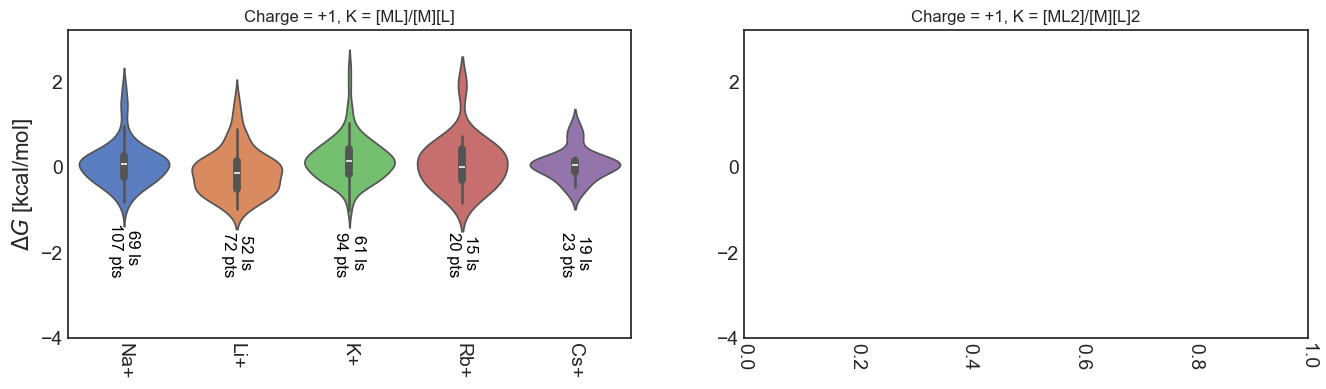

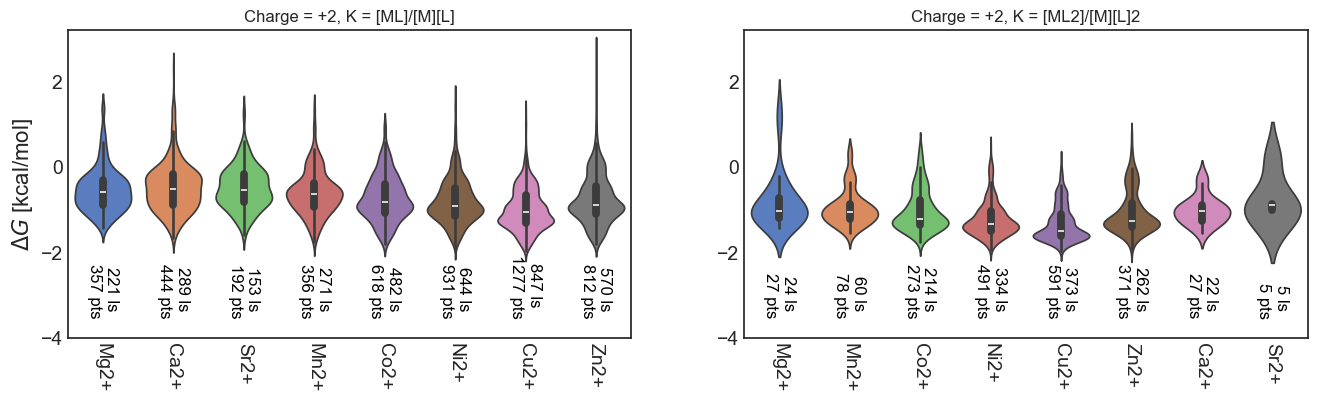

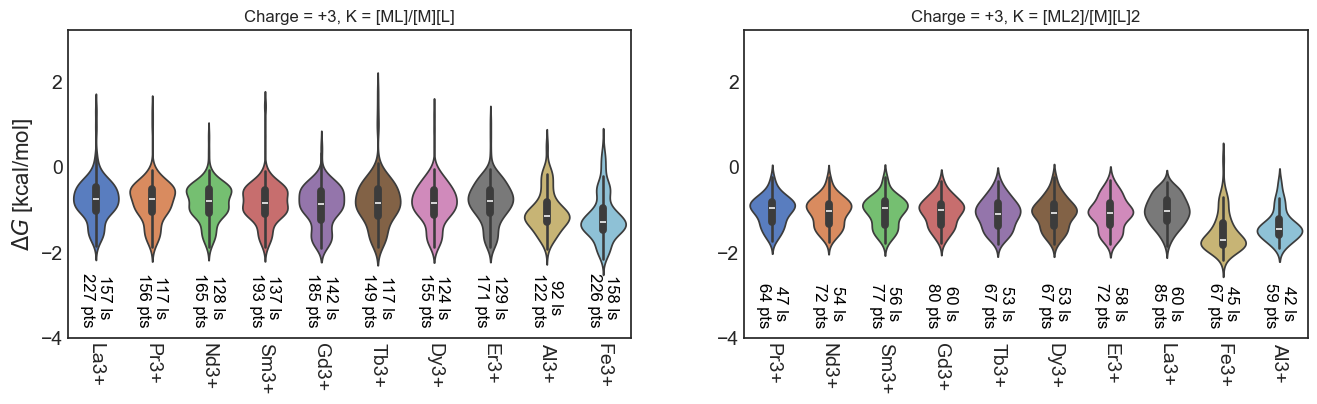

In [17]:
eqlms = ['[ML]/[M][L]', '[ML2]/[M][L]2']

for charge, electrophiles in grouped_by_charge.items():
    print(f"Charge {charge}: {electrophiles}")

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    for i in range(len(eqlms)):
        
        df_c = df[df['Electrophile'].isin(electrophiles)]
        df_c = df_c[df_c['Equilibrium definition'] == eqlms[i]]
        #display(df_c)
        
        # violin plot of data
        sns.violinplot(x='Electrophile', y='delta_G', data=df_c, palette='muted', ax=axs[i])

        for j, electrophile in enumerate(df_c['Electrophile'].unique()):   
            count = df_c[df_c['Electrophile'] == electrophile]['Ligand'].unique().shape[0]
            datapoints = df_c[df_c['Electrophile'] == electrophile].shape[0]
            axs[i].text(j, min(df_c['delta_G'])-1.5, f'{count} ls \n{datapoints} pts',
                    horizontalalignment='center', fontsize=12, color='black', rotation=-90)

        axs[0].set_ylabel(f'$\Delta G$ [kcal/mol]')
        axs[1].set_ylabel('')
        axs[i].set_xlabel('')
        axs[i].set_ylim(-4, 3.2)
        axs[i].tick_params(axis='x', rotation=-90)
        axs[i].set_title(f'Charge = +{charge}, K = {eqlms[i]}')

## Calculate and Assign Molecule Encodings

In [18]:
# remove electrophile datapoints not in the electrophile encoding dataset

df = df[df['Electrophile'].isin(valid_ions)]
print(df.shape)
print(df['Ligand'].unique().shape[0])

(15544, 26)
1267


In [19]:
unique_SMILES = df['smiles'].unique()

mol_encodings = {}

count = 0
max = len(unique_SMILES)
for s in unique_SMILES:
    count += 1
    encoding, features = encode_molecule(s)
    mol_encodings[s] = encoding
    
    clear_output(wait=True)
    print(f"Encoding {count}/{max} complete for {s}")

Encoding 1255/1255 complete for [O-][I+2]([O-])O


In [20]:
# now add the encodings to the dataframe
count = 0
for s in unique_SMILES:
    count += 1
    for i, f in enumerate(features):
        df.loc[df['smiles'] == s, f] = mol_encodings[s][i]
    clear_output(wait=True)
    print(f"Adding {count}/{max} encodings for {s} to df")
        
display(df.head())
df.shape

Adding 1255/1255 encodings for [O-][I+2]([O-])O to df


,Data #,Ligand #,Ligand,Ligand Class,Electrophile #,Electrophile,Equilibrium definition #,Equilibrium definition,Constant #,Constant,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
51,93657,5760,Aminoacetic acid (Glycine),Amino Acids,92,Mg2+,812,[ML]/[M][L],3,K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,93658,5760,Aminoacetic acid (Glycine),Amino Acids,92,Mg2+,812,[ML]/[M][L],3,K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,93659,5760,Aminoacetic acid (Glycine),Amino Acids,92,Mg2+,812,[ML]/[M][L],3,K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,93660,5760,Aminoacetic acid (Glycine),Amino Acids,92,Mg2+,812,[ML]/[M][L],3,K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,93661,5760,Aminoacetic acid (Glycine),Amino Acids,92,Mg2+,812,[ML]/[M][L],3,K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(15544, 235)

## Add on the electrophile properties, where appropriate

In [22]:
for e in ephiles:
    ephile_feature_vals = df_e.loc[df_e['Electrophile'] == e][ep_features]
    
    df.loc[df['Electrophile'] == e, ep_features] = ephile_feature_vals.values[0]

df.head()

,Data #,Ligand #,Ligand,Ligand Class,Electrophile #,Electrophile,Equilibrium definition #,Equilibrium definition,Constant #,Constant,...,Ion-Water Internuclear Distance [nm],Ionic Radii in Solution [nm],Pauling Crystal Ionic Radii [nm],1st Ionization Energy [eV],2nd Ionization Energy [eV],3rd Ionization Energy [eV],4th Ionization Energy [eV],5th Ionization Energy [eV],Standard Reduction Potentials to Neutral [V],Pauling Electronegativity
51,93657,5760,Aminoacetic acid (Glycine),Amino Acids,92,Mg2+,812,[ML]/[M][L],3,K,...,0.209,0.07,0.072,7.6462,15.03527,80.1437,109.2655,141.27,-2.372,1.31
52,93658,5760,Aminoacetic acid (Glycine),Amino Acids,92,Mg2+,812,[ML]/[M][L],3,K,...,0.209,0.07,0.072,7.6462,15.03527,80.1437,109.2655,141.27,-2.372,1.31
53,93659,5760,Aminoacetic acid (Glycine),Amino Acids,92,Mg2+,812,[ML]/[M][L],3,K,...,0.209,0.07,0.072,7.6462,15.03527,80.1437,109.2655,141.27,-2.372,1.31
54,93660,5760,Aminoacetic acid (Glycine),Amino Acids,92,Mg2+,812,[ML]/[M][L],3,K,...,0.209,0.07,0.072,7.6462,15.03527,80.1437,109.2655,141.27,-2.372,1.31
55,93661,5760,Aminoacetic acid (Glycine),Amino Acids,92,Mg2+,812,[ML]/[M][L],3,K,...,0.209,0.07,0.072,7.6462,15.03527,80.1437,109.2655,141.27,-2.372,1.31


## Filter data as needed and save for later

In [ ]:
# 1 -- K = [ML]/[M][L], all electrophiles for which we have data collected, only columns of interest

cols_to_drop = ['Data #', 'Ligand #', 'Ligand Class', 'Electrophile #', 'Equilibrium definition', 'Constant #',
                'Constant', 'Temp (degC)', 'µM? ionic strength', 'Data 1', 'Data 2', 'Range in Literature',
                'Footnote?', 'The solvent is all water', 'Constant.1', 'Constant description', 'Data 1 Units',
                'Data 2 Units', 'name_1', 'name_2', 'mean_val']

cols_to_keep = [i for i in df.columns if i not in cols_to_drop]

dff = df[df['Equilibrium definition'] == '[ML]/[M][L]']
dff = dff[dff['Electrophile'].isin(ephiles)]
dff = dff[cols_to_keep]

dff = dff.dropna(axis=0, inplace=False)

dff = dff.loc[:, dff.apply(pd.Series.nunique) != 1]

display(dff.head())
print(list(dff.columns))

rows, columns = dff.shape
print(f"Rows: {rows}")
print(f"Columns: {columns}")

num_unique_ligands = dff['Ligand'].unique().shape[0]
num_unique_smiles = dff['smiles'].unique().shape[0]
num_unique_ions = dff['Electrophile'].unique().shape[0]

print(f"Number of unique ligands: {num_unique_ligands}")
print(f"Number of unique smiles: {num_unique_smiles}")
print(f"Number of unique ions: {num_unique_ions}")

# 1 - Save the data
save_df = False
if save_df:
    dff.to_csv("../Outputs/Featurized NIST46 Dataset for Model Training/AllMolEncodings+set5-2_ion-encodings.csv", index=False)

,Ligand,Electrophile,smiles,delta_G,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,Ion-Water Internuclear Distance [nm],Ionic Radii in Solution [nm],Pauling Crystal Ionic Radii [nm],1st Ionization Energy [eV],2nd Ionization Energy [eV],3rd Ionization Energy [eV],4th Ionization Energy [eV],5th Ionization Energy [eV],Standard Reduction Potentials to Neutral [V],Pauling Electronegativity
51,Aminoacetic acid (Glycine),Mg2+,NCC(=O)O,-0.300251,9.243056,9.243056,0.277778,-0.967593,0.421171,7.4,...,0.209,0.07,0.072,7.6462,15.03527,80.1437,109.2655,141.27,-2.372,1.31
52,Aminoacetic acid (Glycine),Mg2+,NCC(=O)O,-0.173385,9.243056,9.243056,0.277778,-0.967593,0.421171,7.4,...,0.209,0.07,0.072,7.6462,15.03527,80.1437,109.2655,141.27,-2.372,1.31
53,Aminoacetic acid (Glycine),Mg2+,NCC(=O)O,-0.152824,9.243056,9.243056,0.277778,-0.967593,0.421171,7.4,...,0.209,0.07,0.072,7.6462,15.03527,80.1437,109.2655,141.27,-2.372,1.31
54,Aminoacetic acid (Glycine),Mg2+,NCC(=O)O,-0.251939,9.243056,9.243056,0.277778,-0.967593,0.421171,7.4,...,0.209,0.07,0.072,7.6462,15.03527,80.1437,109.2655,141.27,-2.372,1.31
55,Aminoacetic acid (Glycine),Mg2+,NCC(=O)O,-0.433872,9.243056,9.243056,0.277778,-0.967593,0.421171,7.4,...,0.209,0.07,0.072,7.6462,15.03527,80.1437,109.2655,141.27,-2.372,1.31


['Ligand', 'Electrophile', 'smiles', 'delta_G', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA